## Image classification NIN

***NOTE***

Be sure to use hardware acceleration to use the GPU. Click on `Runtime`, change `runtime type`, and select `GPU` for the *hardware accelerator* option.

* LeNet, AlexNet, and VGG all share a common design pattern: extract features exploiting spatial structure via a sequence of convolutions and pooling layers and post-process the representations via fully connected layers. The improvements upon LeNet by AlexNet and VGG mainly lie in how these later networks widen and deepen these two modules.

* This design poses two major challenges. First, the fully connected layers at the end of the architecture consume tremendous numbers of parameters. This is a significant impediment to speedy computation, in particular on mobile and embedded devices.

* Second, it is equally impossible to add fully connected layers earlier in the network to increase the degree of nonlinearity: doing so would destroy the spatial structure and require potentially even more memory.

* The network in network (NiN) blocks of [Lin et al., 2013] offer an alternative, capable of solving both problems in one simple strategy. They were proposed based on a very simple insight: 

* (i) **use 1x1 convolutions** to add local nonlinearities across the channel activations and 

* (ii) **use global average pooling** to integrate across all locations in the last representation layer. 

* The significant difference between NiN and both AlexNet and VGG is that NiN avoids fully connected layers altogether. Instead, NiN uses a NiN block with a number of output channels equal to the number of label classes, followed by a global average pooling layer, yielding a vector of logits. This design significantly reduces the number of required model parameters, albeit at the expense of a potential increase in training time.

* Global average pooling determines the average value across each channel. So if there are 128 channels in the input feature map, then the output will be 128 values.

![From LeNet (left) to AlexNet (right).](https://d2l.ai/_images/nin.svg)

(left AlexNet, right VGG)

## Imports first

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten
%matplotlib inline

import tensorflow as tf
print(tf.__version__)

2.9.2


## 1x1 convolution

* The depth of the input or number of filters used in convolutional layers often increases with the depth of the network, resulting in an increase in the number of resulting feature maps. It is a common model design pattern.

* A large number of feature maps in a convolutional neural network can cause a problem as a convolutional operation must be performed down through the depth of the input. This is a particular problem if the convolutional operation being performed is relatively large, such as 5×5 or 7×7 pixels, as it can result in considerably more parameters (weights) and, in turn, computation to perform the convolutional operations

* Pooling layers are designed to downscale feature maps and systematically halve the width and height of feature maps in the network. Nevertheless, pooling layers do not change the number of filters in the model, the depth, or number of channels.

* The solution is to use a 1×1 filter to down sample the depth or number of feature maps. A 1×1 filter will only have a single parameter or weight for each channel in the input, and like the application of any filter results in a single output value.

* This structure allows the 1×1 filter to act like a single neuron with an input from the same position across each of the feature maps in the input. This single neuron can then be applied systematically with a stride of one, left-to-right and top-to-bottom without any need for padding, resulting in a feature map with the same width and height as the input.

* The 1×1 filter is so simple that it does not involve any neighboring pixels in the input; it may not be considered a convolutional operation. Instead, it is a linear weighting or projection of the input. Further, a nonlinearity is used as with other convolutional layers, allowing the projection to perform non-trivial computation on the input feature maps.

* This simple 1×1 filter provides a way to usefully summarize the input feature maps. The use of multiple 1×1 filters, in turn, allows the tuning of the number of summaries of the input feature maps to create, effectively allowing the depth of the feature maps to be increased or decreased as needed.

A convolutional layer with a 1×1 filter can, therefore, be used at any point in a convolutional neural network to control the number of feature maps. As such, it is often referred to as a projection operation or projection layer, or even a feature map or channel pooling layer.

In NiN, the depth of the 1x1 convolutionais is the same (i.e. the number of filters created is the same as in input feature map). So the depth is not reduced.

### Next, let's see two examples

In [ ]:
model = tf.keras.Sequential()
model.add(Conv2D(512, (3,3), padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(Conv2D(512, (1,1), activation='relu'))
# summarize model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 512)     14336     
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 512)     262656    
                                                                 
Total params: 276,992
Trainable params: 276,992
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = tf.keras.Sequential()
model.add(Conv2D(512, (3,3), padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(Conv2D(64, (1,1), activation='relu'))
# summarize model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 256, 256, 512)     14336     
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 64)      32832     
                                                                 
Total params: 47,168
Trainable params: 47,168
Non-trainable params: 0
_________________________________________________________________


<hr>

## Load the dataset

In [ ]:
# load data
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


## View the shape

In [ ]:
print('Training data shape : ', X_train.shape, Y_train.shape)

Training data shape :  (60000, 28, 28) (60000,)


In [ ]:
print('Testing data shape : ', X_test.shape, Y_test.shape)

Testing data shape :  (10000, 28, 28) (10000,)


## Find the unique numbers from the train labels

In [ ]:
classes = np.unique(Y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


## Plot some of the data

Text(0.5, 1.0, 'Ground Truth : 1')

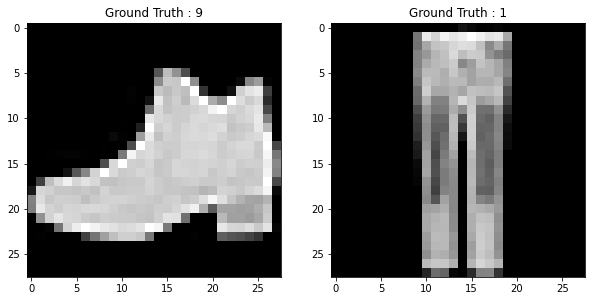

In [ ]:
data_point = 15

plt.figure(figsize=[10,5])
 
# Display the first image in training data
plt.subplot(121)
plt.imshow(X_train[data_point,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(Y_train[data_point]))
 
# Display the first image in testing data
plt.subplot(122)
plt.imshow(X_test[data_point,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(Y_test[data_point]))

## Reshape needed

Keras wants to know the depth of an image. 

For CNNS, Keras wants the format of the data as follows: [batches, width, height, depth]. 

In this case the colour channel/depth of the images is 1. Currently the shape is:

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
X_train.shape

(60000, 28, 28)

But this doesn't have a depth value. So we can reshape it

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

In [ ]:
X_train.shape

(60000, 28, 28, 1)

In [ ]:
X_train.shape

(60000, 28, 28, 1)

## View the shape

In [ ]:
print('Training data shape : ', X_train.shape, Y_train.shape)

Training data shape :  (60000, 28, 28, 1) (60000,)


In [ ]:
print('Testing data shape : ', X_test.shape, Y_test.shape)

Testing data shape :  (10000, 28, 28, 1) (10000,)


## Convert from categorical labels to one-hot encoded vectors

In this case there are 10 classes so we can tell the function to convert into a vector of length 10

In [ ]:
Y_train = np_utils.to_categorical(Y_train, 10)
Y_test = np_utils.to_categorical(Y_test, 10)
num_classes = 10

## Small twist!

API: https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [ ]:
def resize_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)

    image = tf.image.resize(image, (224,224))
    return image, label

In [ ]:
train_ds = (train_ds
                  .map(resize_images)
                  .shuffle(buffer_size=10000)
                  .batch(batch_size=64, drop_remainder=True))
test_ds = (test_ds
                  .map(resize_images)
                  .batch(batch_size=10, drop_remainder=False))

## Create a CNN model

In [ ]:
def baseline_model():
    # create model
    model = tf.keras.Sequential()

    # NiN block 1
    # *********************************************
    model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4,
                                   activation='relu', input_shape=(224,224,1)))
    model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=1, strides=1,
                                   activation='relu'))
    model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=1, strides=1,
                                   activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2))

    # NiN block 2
    # *********************************************
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same',
                                   activation='relu'))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=1, strides=1,
                                   activation='relu'))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=1, strides=1,
                                   activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2))

    # NiN block 3
    # *********************************************
    model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                                   activation='relu'))
    model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=1, strides=1,
                                   activation='relu'))
    model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=1, strides=1,
                                   activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2))

    # NiN block 4
    # *********************************************
    model.add(tf.keras.layers.Conv2D(filters=10, kernel_size=3, padding='same',
                                   activation='relu'))
    model.add(tf.keras.layers.Conv2D(filters=10, kernel_size=1, strides=1,
                                   activation='relu'))
    model.add(tf.keras.layers.Conv2D(filters=10, kernel_size=1, strides=1,
                                   activation='relu'))
    model.add(tf.keras.layers.GlobalAvgPool2D())

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Activation("softmax"))


    # Compile the model
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
    return model

In [ ]:
model = baseline_model()

## Determine the number of trainable parameters

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 54, 54, 96)        11712     
                                                                 
 conv2d_5 (Conv2D)           (None, 54, 54, 96)        9312      
                                                                 
 conv2d_6 (Conv2D)           (None, 54, 54, 96)        9312      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 conv2d_8 (Conv2D)           (None, 26, 26, 256)       65792     
                                                      

* NiN has dramatically fewer parameters than AlexNet and VGG. 

* This stems from the fact that it needs no giant fully connected layers and fewer convolutions with wide kernels. Instead, it uses local  convolutions and global average pooling. 

## Begin training

In [ ]:
model.fit(train_ds, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
937/937 [==============================] - 90s 80ms/step - loss: 1.3859 - accuracy: 0.5367
Epoch 2/10
937/937 [==============================] - 75s 78ms/step - loss: 1.0207 - accuracy: 0.6554
Epoch 3/10
937/937 [==============================] - 75s 77ms/step - loss: 0.8446 - accuracy: 0.6856
Epoch 4/10
937/937 [==============================] - 75s 78ms/step - loss: 0.7926 - accuracy: 0.7092
Epoch 5/10
937/937 [==============================] - 75s 78ms/step - loss: 0.7521 - accuracy: 0.7196
Epoch 6/10
937/937 [==============================] - 75s 77ms/step - loss: 0.7276 - accuracy: 0.7277
Epoch 7/10
937/937 [==============================] - 74s 77ms/step - loss: 0.7055 - accuracy: 0.7344
Epoch 8/10
937/937 [==============================] - 74s 77ms/step - loss: 0.6903 - accuracy: 0.7392
Epoch 9/10
937/937 [==============================] - 74s 77ms/step - loss: 0.6762 - accuracy: 0.7434
Epoch 10/10
937/937 [==============================] - 74s 77ms/step - loss: 0.659

## Predict on all the test data

In [ ]:
predictions = model.predict(test_ds)

1000/1000 [==============================] - 6s 5ms/step


In [ ]:
predictions.shape

(10000, 10)

In [ ]:
correct_values = np.argmax(Y_test,axis=-1)
predicted_classes = np.argmax(predictions,axis=-1)

In [ ]:
accuracy_score(predicted_classes,correct_values)*100

72.87

### More efficient (or rather, less RAM intensive) way:

In [ ]:
targets = []
for x,y in test_ds.as_numpy_iterator():
  targets.extend(y)

In [ ]:
np.asarray(targets).shape

(10000, 10)

In [ ]:
accuracy_score(predicted_classes,np.argmax(targets,axis=-1))*100

72.87

## Tasks:

* Simplify the network so that it roughly takes less than 40 seconds to run 1 epoch. Your network should contain 1x1 convolutions. You can modify hyper-parameters

* Who got the best testing performance with the least number of parameters?